<a href="https://colab.research.google.com/github/tyri0n11/Fraud-Detection-Kaggle/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fraud Detection") \
    .getOrCreate()

In [2]:
df = spark.read.csv("Final Transaction.csv", header=True, inferSchema=True)
df.show(5)
df.dropna()
df.printSchema()

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|                0|
|  2|             2|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|                1|
|  3|             3|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|                0|
|  4|             4|2023-01-01 00:10:34|        927|       9906|   490.66|         

In [3]:
df_clean = df.drop('_c0','TRANSACTION_ID', 'TX_FRAUD_SCENARIO')
df_clean.show(5)

+-------------------+-----------+-----------+---------+---------------+------------+--------+
|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|
+-------------------+-----------+-----------+---------+---------------+------------+--------+
|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|
|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|
|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|
|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|
|2023-01-01 00:10:34|        927|       9906|   490.66|            634|           0|       0|
+-------------------+-----------+-----------+---------+---------------+------------+--------+
only showing top 5 rows


In [4]:
from pyspark.sql.functions import col

df_clean = df_clean.filter(col("TX_FRAUD").isNotNull())


In [5]:
from pyspark.sql.functions import expr, hour, dayofweek

df_clean = df_clean.withColumn(
    "TX_DATETIME",
    expr("try_to_timestamp(TX_DATETIME, 'yyyy-MM-dd HH:mm:ss')")
)

df_clean = df_clean.withColumn("TX_HOUR", hour("TX_DATETIME")) \
                   .withColumn("TX_DAYOFWEEK", dayofweek("TX_DATETIME")) \
                   .drop("TX_DATETIME")



df_clean.show(5)
df_clean.printSchema()

+-----------+-----------+---------+---------------+------------+--------+-------+------------+
|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_HOUR|TX_DAYOFWEEK|
+-----------+-----------+---------+---------------+------------+--------+-------+------------+
|        596|       3156|   533.07|             31|           0|       0|      0|           1|
|       4961|       3412|   808.56|            130|           0|       0|      0|           1|
|          2|       1365|  1442.94|            476|           0|       1|      0|           1|
|       4128|       8737|   620.65|            569|           0|       0|      0|           1|
|        927|       9906|   490.66|            634|           0|       0|      0|           1|
+-----------+-----------+---------+---------------+------------+--------+-------+------------+
only showing top 5 rows
root
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (null

## Data Exploration Chi Tiết

Phân tích dataset để hiểu rõ hơn về cấu trúc, phân phối và các đặc điểm của dữ liệu.


In [6]:
# ============================================
# 1. Thống kê mô tả (Descriptive Statistics)
# ============================================
print("=" * 60)
print("THỐNG KÊ MÔ TẢ CHO CÁC FEATURES")
print("=" * 60)

# Thống kê cho numerical features
numerical_cols = ["TX_AMOUNT", "TX_TIME_SECONDS", "TX_TIME_DAYS", "TX_HOUR", "TX_DAYOFWEEK"]
df_clean.select(numerical_cols).describe().show()

# Thống kê cho categorical features
print("\n" + "=" * 60)
print("THỐNG KÊ CHO CATEGORICAL FEATURES")
print("=" * 60)
print("\nSố lượng unique customers:", df_clean.select("CUSTOMER_ID").distinct().count())
print("Số lượng unique terminals:", df_clean.select("TERMINAL_ID").distinct().count())


THỐNG KÊ MÔ TẢ CHO CÁC FEATURES
+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|        TX_AMOUNT|   TX_TIME_SECONDS|      TX_TIME_DAYS|           TX_HOUR|      TX_DAYOFWEEK|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|           542401|            542401|            542401|            542401|            542401|
|   mean| 537.931293839793| 2441692.216400781| 27.76203399330016|11.459988089992459| 3.970296883670937|
| stddev|888.5561814538147|1408655.6517322268|16.304878629853242|5.0537822607665746|2.0110849030475024|
|    min|              0.0|                31|                 0|                 0|                 1|
|    max|          77212.5|           4881929|                56|                23|                 7|
+-------+-----------------+------------------+------------------+------------------+------------------+


THỐNG KÊ CHO CATEGORICAL FEATU

In [7]:
# ============================================
# 2. Phân tích Missing Values
# ============================================
print("=" * 60)
print("PHÂN TÍCH MISSING VALUES")
print("=" * 60)

from pyspark.sql.functions import col, sum as spark_sum, count

# Đếm missing values cho từng cột
total_rows = df_clean.count()
print(f"\nTổng số rows: {total_rows:,}")

missing_stats = []
for col_name in df_clean.columns:
    missing_count = df_clean.filter(col(col_name).isNull()).count()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0
    missing_stats.append((col_name, missing_count, missing_pct))
    if missing_count > 0:
        print(f"{col_name}: {missing_count:,} ({missing_pct:.2f}%)")

if all(missing_count == 0 for _, missing_count, _ in missing_stats):
    print("\n✓ Không có missing values trong dataset!")


PHÂN TÍCH MISSING VALUES

Tổng số rows: 542,401

✓ Không có missing values trong dataset!


In [8]:
# ============================================
# 3. Phân tích Class Distribution
# ============================================
print("=" * 60)
print("PHÂN TÍCH CLASS DISTRIBUTION")
print("=" * 60)

from pyspark.sql.functions import count as spark_count

class_dist = df_clean.groupBy("TX_FRAUD").agg(
    spark_count("*").alias("count")
).orderBy("TX_FRAUD")

class_dist.show()

# Tính tỷ lệ
total = df_clean.count()
fraud_count = df_clean.filter(col("TX_FRAUD") == 1).count()
normal_count = df_clean.filter(col("TX_FRAUD") == 0).count()

print(f"\nTổng số giao dịch: {total:,}")
print(f"Giao dịch bình thường (0): {normal_count:,} ({normal_count/total*100:.2f}%)")
print(f"Giao dịch gian lận (1): {fraud_count:,} ({fraud_count/total*100:.2f}%)")
print(f"\nTỷ lệ imbalance: {normal_count/fraud_count:.2f}:1 (Normal:Fraud)")


PHÂN TÍCH CLASS DISTRIBUTION
+--------+------+
|TX_FRAUD| count|
+--------+------+
|       0|470149|
|       1| 72252|
+--------+------+


Tổng số giao dịch: 542,401
Giao dịch bình thường (0): 470,149 (86.68%)
Giao dịch gian lận (1): 72,252 (13.32%)

Tỷ lệ imbalance: 6.51:1 (Normal:Fraud)


PHÂN TÍCH CORRELATION


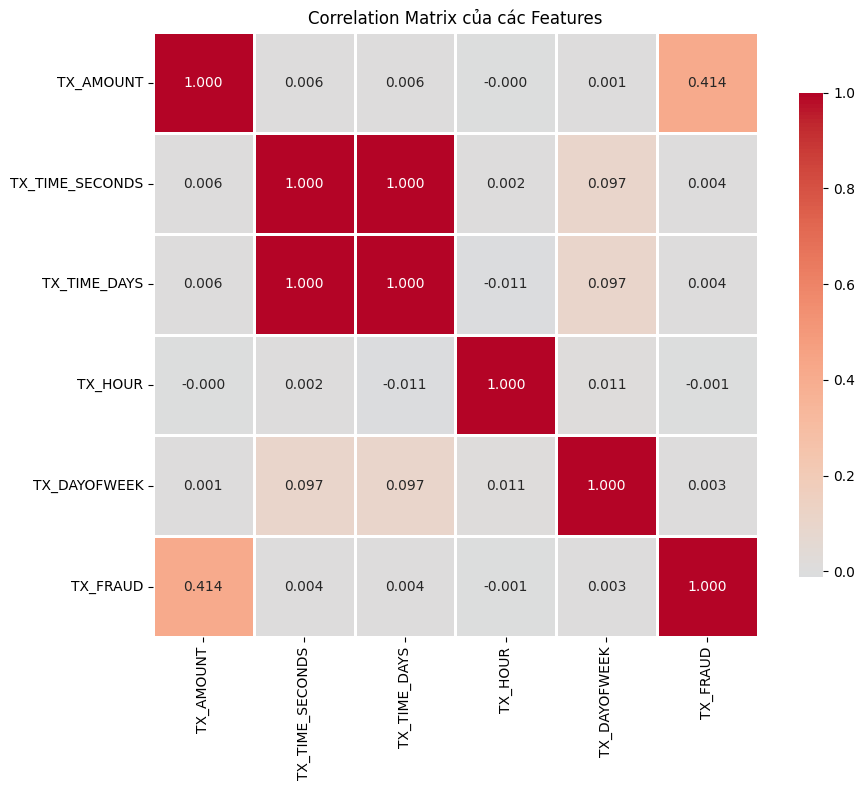


Correlation với TX_FRAUD:
TX_FRAUD           1.000000
TX_AMOUNT          0.413574
TX_TIME_DAYS       0.004386
TX_TIME_SECONDS    0.004367
TX_DAYOFWEEK       0.003065
TX_HOUR           -0.001459
Name: TX_FRAUD, dtype: float64


In [9]:
# ============================================
# 4. Phân tích Correlation (sử dụng Pandas cho visualization)
# ============================================
print("=" * 60)
print("PHÂN TÍCH CORRELATION")
print("=" * 60)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert sang Pandas để tính correlation
pdf_for_corr = df_clean.select(
    "TX_AMOUNT", "TX_TIME_SECONDS", "TX_TIME_DAYS",
    "TX_HOUR", "TX_DAYOFWEEK", "TX_FRAUD"
).toPandas()

correlation_matrix = pdf_for_corr.corr()

# Vẽ correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix của các Features")
plt.tight_layout()
plt.show()

print("\nCorrelation với TX_FRAUD:")
corr_with_fraud = correlation_matrix['TX_FRAUD'].sort_values(ascending=False)
print(corr_with_fraud)


PHÂN TÍCH DISTRIBUTION CỦA TX_AMOUNT


/tmp/ipython-input-1857874432.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_for_box, labels=['Normal', 'Fraud'])


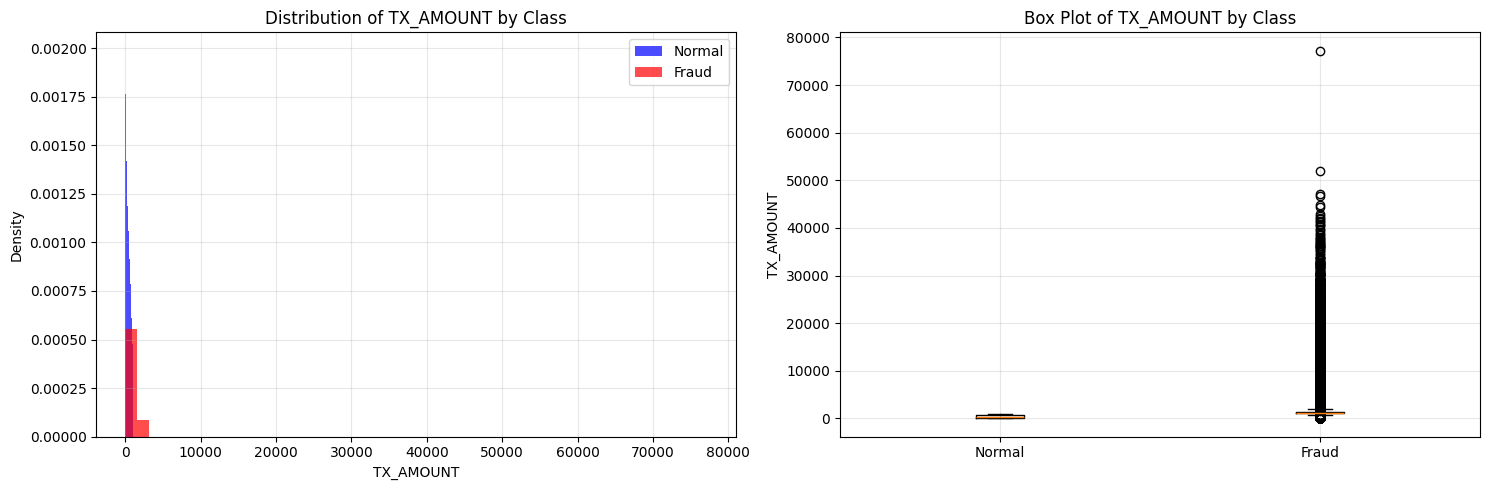


Thống kê TX_AMOUNT theo class:
Normal - Mean: 393.87, Median: 353.39, Std: 275.18
Fraud  - Mean: 1475.34, Median: 1214.34, Std: 2102.52


In [10]:
# ============================================
# 5. Phân tích Distribution của Features theo Fraud Class
# ============================================
print("=" * 60)
print("PHÂN TÍCH DISTRIBUTION CỦA TX_AMOUNT")
print("=" * 60)

# So sánh distribution của TX_AMOUNT giữa fraud và non-fraud
pdf_amount = df_clean.select("TX_AMOUNT", "TX_FRAUD").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
fraud_amounts = pdf_amount[pdf_amount['TX_FRAUD'] == 1]['TX_AMOUNT']
normal_amounts = pdf_amount[pdf_amount['TX_FRAUD'] == 0]['TX_AMOUNT']

axes[0].hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
axes[0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
axes[0].set_xlabel('TX_AMOUNT')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of TX_AMOUNT by Class')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_for_box = [normal_amounts, fraud_amounts]
axes[1].boxplot(data_for_box, labels=['Normal', 'Fraud'])
axes[1].set_ylabel('TX_AMOUNT')
axes[1].set_title('Box Plot of TX_AMOUNT by Class')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê
print("\nThống kê TX_AMOUNT theo class:")
print(f"Normal - Mean: {normal_amounts.mean():.2f}, Median: {normal_amounts.median():.2f}, Std: {normal_amounts.std():.2f}")
print(f"Fraud  - Mean: {fraud_amounts.mean():.2f}, Median: {fraud_amounts.median():.2f}, Std: {fraud_amounts.std():.2f}")


## Feature Engineering Nâng Cao

Tạo các features bổ sung từ dữ liệu giao dịch để cải thiện khả năng dự đoán của model.


In [11]:
# ============================================
# Feature Engineering: Customer-level Statistics
# ============================================
from pyspark.sql import Window
from pyspark.sql.functions import count as spark_count, avg, sum as spark_sum, stddev, max as spark_max, min as spark_min

# Window function để tính statistics theo customer
customer_window = Window.partitionBy("CUSTOMER_ID").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Tính các features theo customer
df_with_customer_features = df_clean.withColumn(
    "CUSTOMER_TX_COUNT",
    spark_count("*").over(customer_window)
).withColumn(
    "CUSTOMER_AVG_AMOUNT",
    avg("TX_AMOUNT").over(customer_window)
).withColumn(
    "CUSTOMER_TOTAL_AMOUNT",
    spark_sum("TX_AMOUNT").over(customer_window)
).withColumn(
    "CUSTOMER_STD_AMOUNT",
    stddev("TX_AMOUNT").over(customer_window)
)

# Tính số lượng giao dịch fraud trước đó của customer
fraud_window = Window.partitionBy("CUSTOMER_ID").rowsBetween(Window.unboundedPreceding, Window.currentRow - 1)
df_with_customer_features = df_with_customer_features.withColumn(
    "CUSTOMER_PREV_FRAUD_COUNT",
    spark_sum((col("TX_FRAUD") == 1).cast("int")).over(fraud_window)
)

print("Customer-level features đã được tạo:")
df_with_customer_features.select(
    "CUSTOMER_ID", "TX_AMOUNT", "TX_FRAUD",
    "CUSTOMER_TX_COUNT", "CUSTOMER_AVG_AMOUNT",
    "CUSTOMER_TOTAL_AMOUNT", "CUSTOMER_STD_AMOUNT",
    "CUSTOMER_PREV_FRAUD_COUNT"
).show(10)


Customer-level features đã được tạo:
+-----------+---------+--------+-----------------+-------------------+---------------------+-------------------+-------------------------+
|CUSTOMER_ID|TX_AMOUNT|TX_FRAUD|CUSTOMER_TX_COUNT|CUSTOMER_AVG_AMOUNT|CUSTOMER_TOTAL_AMOUNT|CUSTOMER_STD_AMOUNT|CUSTOMER_PREV_FRAUD_COUNT|
+-----------+---------+--------+-----------------+-------------------+---------------------+-------------------+-------------------------+
|          1|    76.08|       0|                1|              76.08|                76.08|               NULL|                     NULL|
|          1|   341.56|       0|                2|             208.82|               417.64| 187.72270826940465|                        0|
|          1|   420.15|       0|                3|  279.2633333333333|               837.79| 180.29613759959844|                        0|
|          1|   315.65|       0|                4|             288.36|              1153.44| 148.33114597638172|                 

In [12]:
# ============================================
# Feature Engineering: Terminal-level Statistics
# ============================================
# Window function để tính statistics theo terminal
terminal_window = Window.partitionBy("TERMINAL_ID").rowsBetween(Window.unboundedPreceding, Window.currentRow)

df_with_terminal_features = df_with_customer_features.withColumn(
    "TERMINAL_TX_COUNT",
    spark_count("*").over(terminal_window)
).withColumn(
    "TERMINAL_AVG_AMOUNT",
    avg("TX_AMOUNT").over(terminal_window)
).withColumn(
    "TERMINAL_FRAUD_RATE",
    avg((col("TX_FRAUD") == 1).cast("double")).over(terminal_window)
)

print("Terminal-level features đã được tạo:")
df_with_terminal_features.select(
    "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD",
    "TERMINAL_TX_COUNT", "TERMINAL_AVG_AMOUNT", "TERMINAL_FRAUD_RATE"
).show(10)


Terminal-level features đã được tạo:
+-----------+---------+--------+-----------------+-------------------+-------------------+
|TERMINAL_ID|TX_AMOUNT|TX_FRAUD|TERMINAL_TX_COUNT|TERMINAL_AVG_AMOUNT|TERMINAL_FRAUD_RATE|
+-----------+---------+--------+-----------------+-------------------+-------------------+
|          1|   696.31|       0|                1|             696.31|                0.0|
|          1|   173.61|       0|                2|             434.96|                0.0|
|          1|   1225.1|       1|                3|             698.34| 0.3333333333333333|
|          1|  1012.01|       1|                4|  776.7574999999999|                0.5|
|          1|  1295.25|       1|                5|  880.4559999999999|                0.6|
|          1|  1302.03|       1|                6|  950.7183333333332| 0.6666666666666666|
|          1|   477.13|       0|                7|  883.0628571428571| 0.5714285714285714|
|          1|   402.86|       0|                8|  8

In [13]:
# ============================================
# Feature Engineering: Time-based Features
# ============================================
from pyspark.sql.functions import when, log

# Tạo các time-based features
df_final_features = df_with_terminal_features.withColumn(
    "IS_WEEKEND",
    when((col("TX_DAYOFWEEK") == 1) | (col("TX_DAYOFWEEK") == 7), 1).otherwise(0)
).withColumn(
    "IS_NIGHT",
    when((col("TX_HOUR") >= 22) | (col("TX_HOUR") <= 6), 1).otherwise(0)
).withColumn(
    "IS_BUSINESS_HOURS",
    when((col("TX_HOUR") >= 9) & (col("TX_HOUR") <= 17), 1).otherwise(0)
).withColumn(
    "TX_AMOUNT_LOG",
    log(col("TX_AMOUNT") + 1)  # Log transform để giảm skewness
)

print("Time-based và transformed features đã được tạo:")
df_final_features.select(
    "TX_HOUR", "TX_DAYOFWEEK", "TX_AMOUNT", "TX_AMOUNT_LOG",
    "IS_WEEKEND", "IS_NIGHT", "IS_BUSINESS_HOURS"
).show(10)


Time-based và transformed features đã được tạo:
+-------+------------+---------+------------------+----------+--------+-----------------+
|TX_HOUR|TX_DAYOFWEEK|TX_AMOUNT|     TX_AMOUNT_LOG|IS_WEEKEND|IS_NIGHT|IS_BUSINESS_HOURS|
+-------+------------+---------+------------------+----------+--------+-----------------+
|      0|           1|   533.07| 6.280526916511479|         1|       1|                0|
|      0|           1|   808.56| 6.696490890198005|         1|       1|                0|
|      0|           1|  1442.94| 7.275130767342957|         1|       1|                0|
|      0|           1|   620.65| 6.432377233398946|         1|       1|                0|
|      0|           1|   490.66| 6.197787420691848|         1|       1|                0|
|      0|           1|   401.17| 5.996874884800257|         1|       1|                0|
|      0|           1|   938.54| 6.845390393785406|         1|       1|                0|
|      0|           1|   206.53|5.3352759075335685| 

## Feature Scaling và Preprocessing

Chuẩn hóa các numerical features để cải thiện hiệu suất của các thuật toán machine learning.


In [14]:
# ============================================
# Feature Scaling với StandardScaler
# ============================================
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col, when, isnan, isnull, coalesce
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np

# Cập nhật danh sách features để bao gồm các features mới
feature_cols = [
    "CUSTOMER_ID",
    "TERMINAL_ID",
    "TX_AMOUNT",
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS",
    "TX_HOUR",
    "TX_DAYOFWEEK",
    "CUSTOMER_TX_COUNT",
    "CUSTOMER_AVG_AMOUNT",
    "CUSTOMER_TOTAL_AMOUNT",
    "CUSTOMER_STD_AMOUNT",
    "CUSTOMER_PREV_FRAUD_COUNT",
    "TERMINAL_TX_COUNT",
    "TERMINAL_AVG_AMOUNT",
    "TERMINAL_FRAUD_RATE",
    "IS_WEEKEND",
    "IS_NIGHT",
    "IS_BUSINESS_HOURS",
    "TX_AMOUNT_LOG"
]

# ============================================
# Bước 1: Fill NaN, null và Infinity values
# ============================================
print("Đang xử lý NaN, null và Infinity values...")

# Fill NaN cho các features có thể có NaN từ window functions
df_cleaned = df_final_features

# Hàm để xử lý NaN và null trong một cột
# Lưu ý: Infinity sẽ được xử lý trong vector bằng UDF
def clean_column(df, col_name, default_value=0.0):
    """Xử lý NaN và null trong một cột"""
    return df.withColumn(
        col_name,
        when(
            (isnan(col_name)) |
            (isnull(col_name)),
            default_value
        ).otherwise(col(col_name))
    )

# Fill NaN và Infinity cho CUSTOMER_STD_AMOUNT (stddev có thể NaN khi chỉ có 1 giá trị)
df_cleaned = clean_column(df_cleaned, "CUSTOMER_STD_AMOUNT", 0.0)

# Fill NaN và Infinity cho CUSTOMER_PREV_FRAUD_COUNT
df_cleaned = clean_column(df_cleaned, "CUSTOMER_PREV_FRAUD_COUNT", 0.0)

# Fill NaN cho CUSTOMER_AVG_AMOUNT (nếu có)
# Lưu ý: Infinity sẽ được xử lý trong vector bằng UDF
df_cleaned = df_cleaned.withColumn(
    "CUSTOMER_AVG_AMOUNT",
    when(
        (isnan("CUSTOMER_AVG_AMOUNT")) |
        (isnull("CUSTOMER_AVG_AMOUNT")),
        col("TX_AMOUNT")
    ).otherwise(col("CUSTOMER_AVG_AMOUNT"))
)

# Fill NaN cho TERMINAL_AVG_AMOUNT (nếu có)
# Lưu ý: Infinity sẽ được xử lý trong vector bằng UDF
df_cleaned = df_cleaned.withColumn(
    "TERMINAL_AVG_AMOUNT",
    when(
        (isnan("TERMINAL_AVG_AMOUNT")) |
        (isnull("TERMINAL_AVG_AMOUNT")),
        col("TX_AMOUNT")
    ).otherwise(col("TERMINAL_AVG_AMOUNT"))
)

# Fill NaN và Infinity cho TERMINAL_FRAUD_RATE
df_cleaned = clean_column(df_cleaned, "TERMINAL_FRAUD_RATE", 0.0)

# Fill NaN và Infinity cho các features khác nếu có
for col_name in feature_cols:
    if col_name not in ["CUSTOMER_STD_AMOUNT", "CUSTOMER_PREV_FRAUD_COUNT",
                        "CUSTOMER_AVG_AMOUNT", "TERMINAL_AVG_AMOUNT", "TERMINAL_FRAUD_RATE"]:
        df_cleaned = clean_column(df_cleaned, col_name, 0.0)

# Kiểm tra số lượng NaN sau khi fill
print("Kiểm tra NaN sau khi fill:")
for col_name in feature_cols:
    nan_count = df_cleaned.filter(
        (isnan(col_name)) |
        (isnull(col_name))
    ).count()
    if nan_count > 0:
        print(f"  {col_name}: {nan_count} NaN/null values")

# ============================================
# Bước 2: Tạo vector assembler và xử lý NaN/Inf trong vectors
# ============================================
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw",
    handleInvalid="keep"  # Giữ lại và fill NaN bằng 0
)

# Transform data
df_assembled = assembler.transform(df_cleaned)

# Hàm UDF để xử lý NaN/Infinity trong vector
def replace_nan_inf_in_vector(vector):
    """Thay thế NaN và Infinity trong vector bằng 0"""
    if vector is None:
        return Vectors.dense([0.0] * len(feature_cols))
    arr = vector.toArray()
    # Thay thế NaN và Infinity bằng 0
    arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
    return Vectors.dense(arr)

replace_nan_udf = udf(replace_nan_inf_in_vector, VectorUDT())

# Xử lý NaN/Infinity trong features_raw TRƯỚC KHI đưa vào StandardScaler
df_assembled = df_assembled.withColumn(
    "features_raw",
    replace_nan_udf(col("features_raw"))
)

# ============================================
# Bước 3: Apply StandardScaler
# ============================================
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# ============================================
# Bước 4: Xử lý NaN/Infinity sau StandardScaler (QUAN TRỌNG!)
# ============================================
# StandardScaler có thể tạo ra NaN/Infinity khi std = 0 hoặc có vấn đề khác
# Đảm bảo xử lý triệt để sau khi scaling
df_scaled = df_scaled.withColumn(
    "features",
    replace_nan_udf(col("features"))
)

# Tạo DataFrame cho ML
df_ml = df_scaled.select("features", "TX_FRAUD")

print("\nFeatures đã được scaled và cleaned:")
print(f"Số lượng features: {len(feature_cols)}")
df_ml.show(3, truncate=False)

# Kiểm tra lại NaN/Infinity trong features (kiểm tra nhiều samples hơn)
print("\nKiểm tra NaN/Infinity trong feature vectors:")
sample_features = df_ml.select("features").take(100)
nan_rows = 0
inf_rows = 0
for i, row in enumerate(sample_features):
    vec = row.features
    if vec:
        arr = vec.toArray()
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()
        if nan_count > 0:
            nan_rows += 1
            if nan_rows <= 5:  # Chỉ in 5 dòng đầu tiên
                print(f"  Row {i}: {nan_count} NaN values")
        if inf_count > 0:
            inf_rows += 1
            if inf_rows <= 5:  # Chỉ in 5 dòng đầu tiên
                print(f"  Row {i}: {inf_count} Inf values")

if nan_rows == 0 and inf_rows == 0:
    print("  ✓ Tất cả vectors đều OK (không có NaN/Infinity)")
else:
    print(f"  ⚠ Cảnh báo: {nan_rows} rows có NaN, {inf_rows} rows có Infinity")
    print("  Đang xử lý lại...")
    # Xử lý lại một lần nữa để đảm bảo
    df_ml = df_ml.withColumn(
        "features",
        replace_nan_udf(col("features"))
    )
    print("  ✓ Đã xử lý lại")


Đang xử lý NaN, null và Infinity values...
Kiểm tra NaN sau khi fill:

Features đã được scaled và cleaned:
Số lượng features: 19
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                                                                                                                                                                                                                                                                                  |TX_FRAUD|
+------------------------------------------------------------------------------------------

## Cải Thiện Model Evaluation - Đầy Đủ Metrics

Tạo hàm để tính toán tất cả các metrics quan trọng cho classification.


In [15]:
# ============================================
# Hàm tính toán đầy đủ metrics
# ============================================
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import precision_recall_curve, auc as sklearn_auc
import pandas as pd

def calculate_all_metrics(predictions, label_col="TX_FRAUD", prediction_col="prediction", prob_col="probability"):
    """
    Tính toán tất cả các metrics cho binary classification
    """
    # Binary Classification Metrics
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol=label_col,
        metricName="areaUnderROC"
    )
    auc = auc_evaluator.evaluate(predictions)

    # Multiclass Classification Metrics
    evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol=prediction_col
    )

    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    # Tính Precision, Recall, F1 cho từng class
    pdf = predictions.select(label_col, prediction_col, prob_col).toPandas()
    y_true = pdf[label_col].values
    y_pred = pdf[prediction_col].values

    # Confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrics cho class 1 (Fraud)
    if len(cm) == 2:
        tn, fp, fn, tp = cm.ravel()
        precision_class1 = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_class1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1) if (precision_class1 + recall_class1) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        precision_class1 = recall_class1 = f1_class1 = specificity = 0

    # Precision-Recall AUC
    y_proba = pdf[prob_col].apply(lambda x: x[1] if len(x) > 1 else x[0]).values
    pr_precision, pr_recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = sklearn_auc(pr_recall, pr_precision)

    return {
        "AUC-ROC": auc,
        "AUC-PR": pr_auc,
        "Accuracy": accuracy,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall,
        "F1-Score (Weighted)": f1,
        "Precision (Fraud Class)": precision_class1,
        "Recall (Fraud Class)": recall_class1,
        "F1-Score (Fraud Class)": f1_class1,
        "Specificity": specificity,
        "Confusion Matrix": cm
    }

def print_metrics(metrics, model_name):
    """In metrics một cách đẹp mắt"""
    print(f"\n{'='*60}")
    print(f"METRICS CHO {model_name}")
    print(f"{'='*60}")
    print(f"AUC-ROC:              {metrics['AUC-ROC']:.4f}")
    print(f"AUC-PR:                {metrics['AUC-PR']:.4f}")
    print(f"Accuracy:              {metrics['Accuracy']:.4f}")
    print(f"Precision (Weighted):  {metrics['Precision (Weighted)']:.4f}")
    print(f"Recall (Weighted):     {metrics['Recall (Weighted)']:.4f}")
    print(f"F1-Score (Weighted):   {metrics['F1-Score (Weighted)']:.4f}")
    print(f"\n--- Metrics cho Fraud Class (Class 1) ---")
    print(f"Precision:             {metrics['Precision (Fraud Class)']:.4f}")
    print(f"Recall:                {metrics['Recall (Fraud Class)']:.4f}")
    print(f"F1-Score:              {metrics['F1-Score (Fraud Class)']:.4f}")
    print(f"Specificity:           {metrics['Specificity']:.4f}")
    print(f"\nConfusion Matrix:")
    print(metrics['Confusion Matrix'])

print("Hàm calculate_all_metrics đã được định nghĩa!")


Hàm calculate_all_metrics đã được định nghĩa!


## Train/Test Split

Chia dataset thành training và testing sets.


In [16]:
# Train/Test Split với df_ml đã được scaled
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_df.count())
print("Test :", test_df.count())


Train: 433667
Test : 108734


In [17]:
train_df = train_df.cache()
print(train_df.count())

434102


## Baseline Models với Đầy Đủ Metrics

Train và evaluate baseline models với tất cả metrics.


In [18]:
# ============================================
# Baseline Logistic Regression
# ============================================
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="TX_FRAUD",
    maxIter=5
)

lr_model = lr.fit(train_df)
lr_pred = lr_model.transform(test_df)

# Tính đầy đủ metrics
lr_metrics = calculate_all_metrics(lr_pred, label_col="TX_FRAUD")
print_metrics(lr_metrics, "Logistic Regression (Baseline)")



METRICS CHO Logistic Regression (Baseline)
AUC-ROC:              0.9866
AUC-PR:                0.9444
Accuracy:              0.9584
Precision (Weighted):  0.9584
Recall (Weighted):     0.9584
F1-Score (Weighted):   0.9558

--- Metrics cho Fraud Class (Class 1) ---
Precision:             0.9593
Recall:                0.7203
F1-Score:              0.8228
Specificity:           0.9953

Confusion Matrix:
[[93698   446]
 [ 4081 10509]]


In [ ]:
# ============================================
# Baseline XGBoost
# ============================================
from xgboost.spark import SparkXGBClassifier

xgb = SparkXGBClassifier(
    features_col="features",
    label_col="TX_FRAUD",
)

xgb_model = xgb.fit(train_df)
xgb_pred = xgb_model.transform(test_df)

xgb_metrics = calculate_all_metrics(xgb_pred, label_col="TX_FRAUD")
print_metrics(xgb_metrics, "XGBoost (Baseline)")

## Hyperparameter Tuning với Grid Search

Sử dụng Grid Search để tìm hyperparameters tối ưu cho các models.


In [20]:
# ============================================
# Hyperparameter Tuning cho Logistic Regression
# ============================================
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time

print("=" * 60)
print("HYPERPARAMETER TUNING CHO LOGISTIC REGRESSION")
print("=" * 60)

# Tạo parameter grid
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    metricName="areaUnderROC"
)

# Cross Validator
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

# Fit model với cross-validation
print("\nBắt đầu Grid Search cho Logistic Regression...")
start_time = time.time()
lr_cv_model = lr_cv.fit(train_df)
end_time = time.time()

print(f"Hoàn thành trong {end_time - start_time:.2f} giây")

# Best model
lr_best_model = lr_cv_model.bestModel
print(f"\nBest parameters:")
print(f"  regParam: {lr_best_model.getRegParam()}")
print(f"  elasticNetParam: {lr_best_model.getElasticNetParam()}")

# Evaluate best model
lr_tuned_pred = lr_best_model.transform(test_df)
lr_tuned_metrics = calculate_all_metrics(lr_tuned_pred, label_col="TX_FRAUD")
print_metrics(lr_tuned_metrics, "Logistic Regression (Tuned)")


HYPERPARAMETER TUNING CHO LOGISTIC REGRESSION

Bắt đầu Grid Search cho Logistic Regression...
Hoàn thành trong 931.69 giây

Best parameters:
  regParam: 0.01
  elasticNetParam: 1.0

METRICS CHO Logistic Regression (Tuned)
AUC-ROC:              0.9893
AUC-PR:                0.9623
Accuracy:              0.9485
Precision (Weighted):  0.9501
Recall (Weighted):     0.9485
F1-Score (Weighted):   0.9436

--- Metrics cho Fraud Class (Class 1) ---
Precision:             0.9789
Recall:                0.6295
F1-Score:              0.7663
Specificity:           0.9979

Confusion Matrix:
[[93946   198]
 [ 5405  9185]]


In [29]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

xgb = SparkXGBClassifier(
    features_col="features",
    label_col="TX_FRAUD",
    eval_metric="auc",
    tree_method="hist",
    max_depth=6,
    eta=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=42
)
xgb_param_grid = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [4, 6]) \
    .addGrid(xgb.learning_rate, [0.05, 0.1]) \
    .build()

xgb_cv = CrossValidator(
    estimator=xgb,
    estimatorParamMaps=xgb_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4
)

print("\nBắt đầu Grid Search cho XGBoost...")
start_time = time.time()

xgb_cv_model = xgb_cv.fit(train_df)

end_time = time.time()
print(f"Hoàn thành trong {end_time - start_time:.2f} giây")



Bắt đầu Grid Search cho XGBoost...


INFO:XGBoost-PySpark:Running xgboost-3.1.2 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 6, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'hist', 'eta': 0.1, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-3.1.2 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'binary:logistic', 'subsample': 0.8, 'tree_method': 'hist', 'eta': 0.1, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-3.1.2 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_d

Hoàn thành trong 1753.31 giây


## Feature Importance Analysis

Phân tích tầm quan trọng của các features để hiểu model tốt hơn.


In [34]:
booster = xgb_cv_model.bestModel.get_booster()
importance_gain = booster.get_score(importance_type="gain")


FEATURE IMPORTANCE (XGBoost - Gain)
                  Feature  Importance_Gain  Importance_%
                TX_AMOUNT      4041.833984     48.248680
            TX_AMOUNT_LOG      3903.008545     46.591475
      CUSTOMER_AVG_AMOUNT       183.100662      2.185732
      TERMINAL_FRAUD_RATE       100.437981      1.198961
      TERMINAL_AVG_AMOUNT        35.437622      0.423030
             TX_TIME_DAYS        21.224709      0.253366
      CUSTOMER_STD_AMOUNT        21.200722      0.253080
          TX_TIME_SECONDS        13.518830      0.161379
        TERMINAL_TX_COUNT        13.256322      0.158245
              TERMINAL_ID         7.570818      0.090375
CUSTOMER_PREV_FRAUD_COUNT         7.413821      0.088501
        CUSTOMER_TX_COUNT         5.729905      0.068400
    CUSTOMER_TOTAL_AMOUNT         4.267069      0.050937
                 IS_NIGHT         4.182564      0.049929
              CUSTOMER_ID         3.656745      0.043652
             TX_DAYOFWEEK         3.539838      0.04

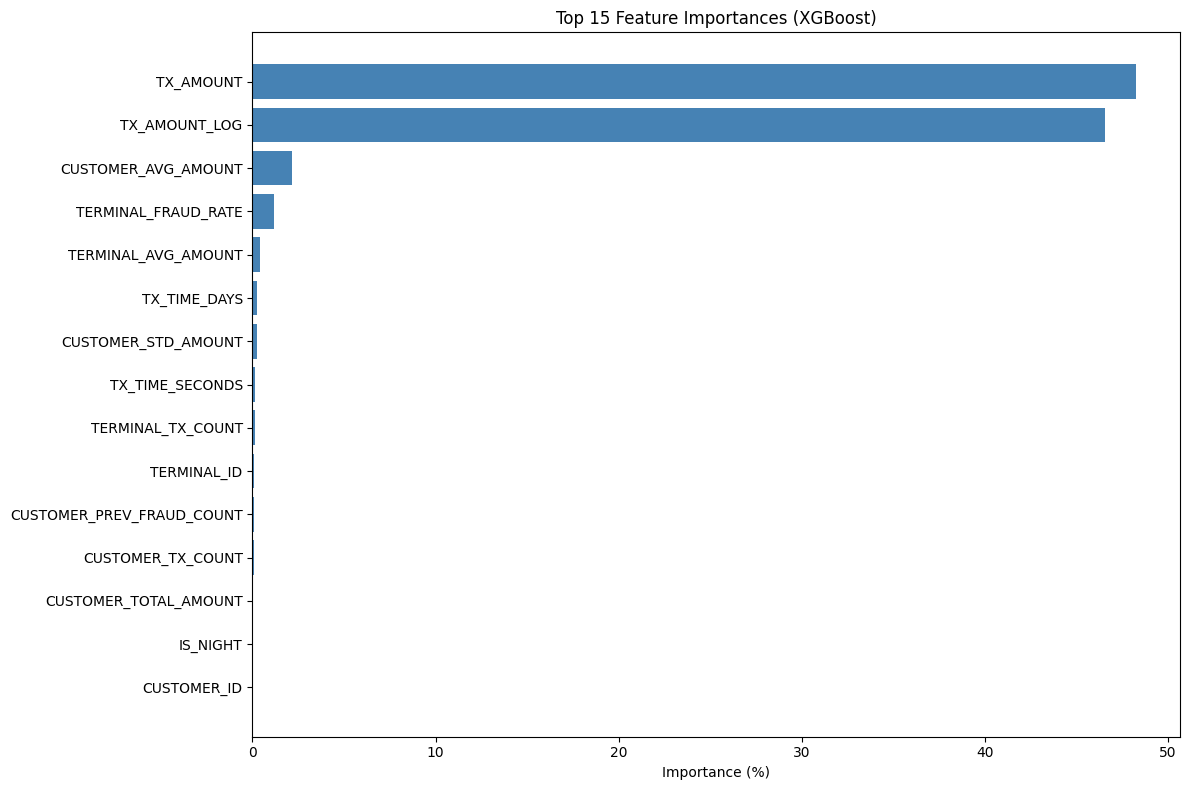

In [35]:
# ============================================
# Feature Importance từ XGBoost (Gain)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# 1. Lấy booster từ best XGBoost model
xgb_best_model = xgb_cv_model.bestModel
booster = xgb_best_model.get_booster()

# 2. Lấy feature importance theo gain (industry standard)
importance_gain = booster.get_score(importance_type="gain")

# 3. Map feature index (f0, f1, ...) -> feature name
feature_names = feature_cols  # giống như LR, đã dùng để build VectorAssembler

rows = []
for k, v in importance_gain.items():
    idx = int(k.replace("f", ""))
    rows.append({
        "Feature": feature_names[idx],
        "Importance_Gain": v
    })

importance_df = (
    pd.DataFrame(rows)
    .sort_values("Importance_Gain", ascending=False)
)

# 4. Chuẩn hóa sang %
importance_df["Importance_%"] = (
    importance_df["Importance_Gain"] / importance_df["Importance_Gain"].sum()
) * 100

print("=" * 60)
print("FEATURE IMPORTANCE (XGBoost - Gain)")
print("=" * 60)
print(importance_df.to_string(index=False))

# 5. Visualization (Top 15 features)
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)

plt.barh(
    range(len(top_features)),
    top_features["Importance_%"],
    color="steelblue"
)
plt.yticks(range(len(top_features)), top_features["Feature"])
plt.xlabel("Importance (%)")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


FEATURE COEFFICIENTS (Logistic Regression)
                  Feature  Coefficient
                TX_AMOUNT     1.870573
            TX_AMOUNT_LOG     1.556266
      TERMINAL_FRAUD_RATE     0.450109
CUSTOMER_PREV_FRAUD_COUNT     0.174410
    CUSTOMER_TOTAL_AMOUNT    -0.170379
      CUSTOMER_AVG_AMOUNT     0.080077
      TERMINAL_AVG_AMOUNT    -0.056079
        CUSTOMER_TX_COUNT    -0.009738
              CUSTOMER_ID     0.000000
              TERMINAL_ID     0.000000
          TX_TIME_SECONDS     0.000000
      CUSTOMER_STD_AMOUNT     0.000000
             TX_TIME_DAYS     0.000000
                  TX_HOUR     0.000000
             TX_DAYOFWEEK     0.000000
        TERMINAL_TX_COUNT     0.000000
               IS_WEEKEND     0.000000
                 IS_NIGHT     0.000000
        IS_BUSINESS_HOURS     0.000000


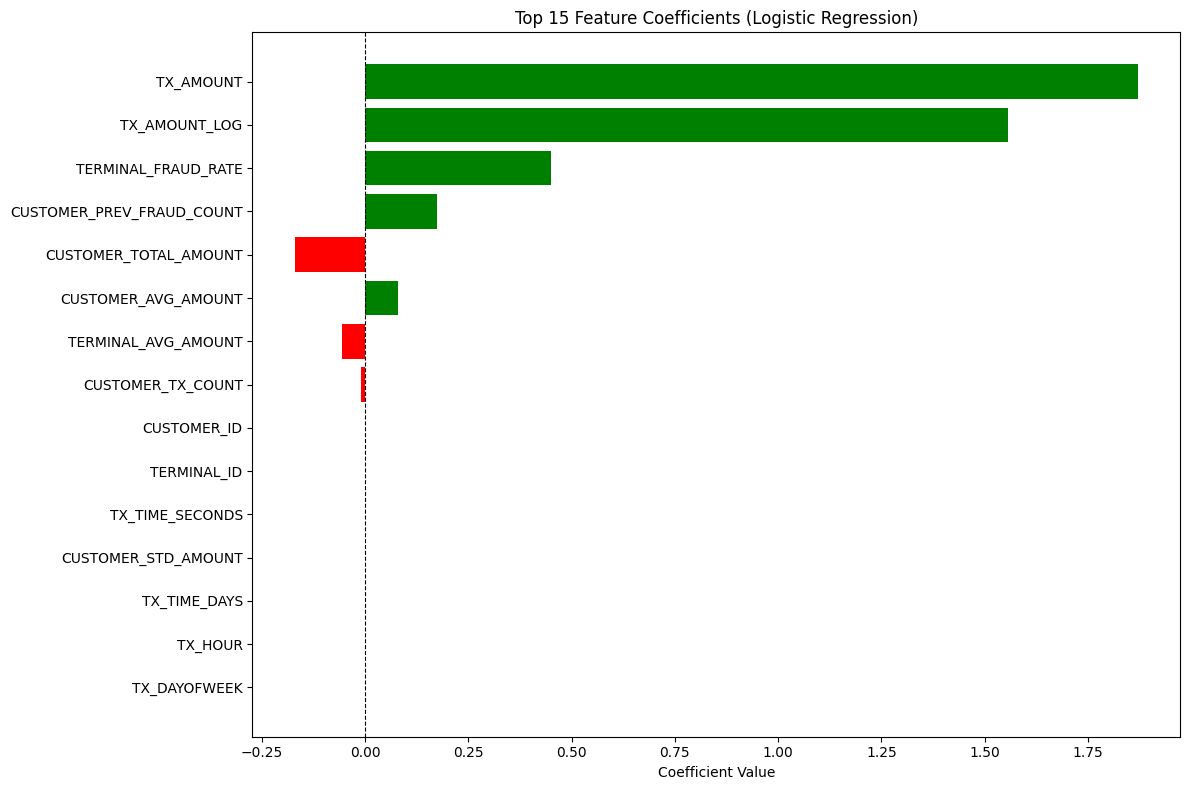

In [30]:
# ============================================
# Coefficients từ Logistic Regression
# ============================================
lr_coefficients = lr_best_model.coefficients.toArray()

# Tạo DataFrame với feature names và coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_coefficients
}).sort_values('Coefficient', key=abs, ascending=False)

print("=" * 60)
print("FEATURE COEFFICIENTS (Logistic Regression)")
print("=" * 60)
print(coefficients_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_coef = coefficients_df.head(15)
colors = ['red' if x < 0 else 'green' for x in top_coef['Coefficient']]
plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors)
plt.yticks(range(len(top_coef)), top_coef['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Precision-Recall Curves

Vẽ Precision-Recall curves cho tất cả models để so sánh hiệu suất trên imbalanced data.


In [36]:
# ============================================
# Precision-Recall Curves cho tất cả models
# ============================================
from sklearn.metrics import precision_recall_curve

def get_pr_data(spark_df, label_col="TX_FRAUD", prob_col="probability"):
    """Lấy data cho Precision-Recall curve"""
    pdf = spark_df.select(label_col, prob_col).toPandas()
    y_true = pdf[label_col].values
    y_proba = pdf[prob_col].apply(lambda x: x[1] if len(x) > 1 else x[0]).values
    return y_true, y_proba

# Lấy data cho các models
lr_y_true, lr_y_proba = get_pr_data(lr_pred)
rf_y_true, rf_y_proba = get_pr_data(rf_pred)
lr_tuned_y_true, lr_tuned_y_proba = get_pr_data(lr_tuned_pred)
rf_tuned_y_true, rf_tuned_y_proba = get_pr_data(rf_tuned_pred)

# Tính Precision-Recall curves
lr_precision, lr_recall, _ = precision_recall_curve(lr_y_true, lr_y_proba)
rf_precision, rf_recall, _ = precision_recall_curve(rf_y_true, rf_y_proba)
lr_tuned_precision, lr_tuned_recall, _ = precision_recall_curve(lr_tuned_y_true, lr_tuned_y_proba)
rf_tuned_precision, rf_tuned_recall, _ = precision_recall_curve(rf_tuned_y_true, rf_tuned_y_proba)

# Tính AUC-PR
lr_pr_auc = sklearn_auc(lr_recall, lr_precision)
rf_pr_auc = sklearn_auc(rf_recall, rf_precision)
lr_tuned_pr_auc = sklearn_auc(lr_tuned_recall, lr_tuned_precision)
rf_tuned_pr_auc = sklearn_auc(rf_tuned_recall, rf_tuned_precision)

# Vẽ Precision-Recall curves
plt.figure(figsize=(10, 8))
plt.plot(lr_recall, lr_precision, color='blue', lw=2,
         label=f'LR Baseline (AUC-PR = {lr_pr_auc:.3f})')
plt.plot(rf_recall, rf_precision, color='green', lw=2,
         label=f'RF Baseline (AUC-PR = {rf_pr_auc:.3f})')
plt.plot(lr_tuned_recall, lr_tuned_precision, color='red', lw=2,
         label=f'LR Tuned (AUC-PR = {lr_tuned_pr_auc:.3f})')
plt.plot(rf_tuned_recall, rf_tuned_precision, color='purple', lw=2,
         label=f'RF Tuned (AUC-PR = {rf_tuned_pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
ERROR:py4j.clientserver:Exception occurred while shutting down connection
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver

KeyboardInterrupt: 

## Spark Performance Optimization

Tối ưu hóa cấu hình Spark để cải thiện hiệu suất.


In [ ]:
# ============================================
# Spark Performance Optimization
# ============================================
print("=" * 60)
print("SPARK CONFIGURATION")
print("=" * 60)

# Hiển thị current Spark config
spark_conf = spark.sparkContext.getConf()
print(f"\nSpark App Name: {spark_conf.get('spark.app.name')}")
print(f"Spark Master: {spark_conf.get('spark.master', 'local[*]')}")

# Cache DataFrames để tăng tốc độ
print("\nCaching training và test DataFrames...")
train_df.cache()
test_df.cache()

# Kiểm tra số partitions
print(f"\nSố partitions của train_df: {train_df.rdd.getNumPartitions()}")
print(f"Số partitions của test_df: {test_df.rdd.getNumPartitions()}")

# Đếm để trigger caching
print("\nĐang cache DataFrames (lần đầu sẽ chậm)...")
train_count = train_df.count()
test_count = test_df.count()
print(f"Train count: {train_count:,}")
print(f"Test count: {test_count:,}")
print("\n✓ DataFrames đã được cache. Các operations tiếp theo sẽ nhanh hơn.")


## So Sánh Tổng Hợp Tất Cả Models

Tạo bảng so sánh tổng hợp cho tất cả models.


In [ ]:
# ============================================
# So sánh tổng hợp tất cả models
# ============================================
print("=" * 60)
print("SO SÁNH TỔNG HỢP TẤT CẢ MODELS")
print("=" * 60)

# Tạo comparison DataFrame
comparison_data = {
    'Model': [
        'LR Baseline',
        'RF Baseline',
        'LR Tuned',
        'RF Tuned'
    ],
    'AUC-ROC': [
        lr_metrics['AUC-ROC'],
        rf_metrics['AUC-ROC'],
        lr_tuned_metrics['AUC-ROC'],
        rf_tuned_metrics['AUC-ROC']
    ],
    'AUC-PR': [
        lr_metrics['AUC-PR'],
        rf_metrics['AUC-PR'],
        lr_tuned_metrics['AUC-PR'],
        rf_tuned_metrics['AUC-PR']
    ],
    'Accuracy': [
        lr_metrics['Accuracy'],
        rf_metrics['Accuracy'],
        lr_tuned_metrics['Accuracy'],
        rf_tuned_metrics['Accuracy']
    ],
    'Precision (Fraud)': [
        lr_metrics['Precision (Fraud Class)'],
        rf_metrics['Precision (Fraud Class)'],
        lr_tuned_metrics['Precision (Fraud Class)'],
        rf_tuned_metrics['Precision (Fraud Class)']
    ],
    'Recall (Fraud)': [
        lr_metrics['Recall (Fraud Class)'],
        rf_metrics['Recall (Fraud Class)'],
        lr_tuned_metrics['Recall (Fraud Class)'],
        rf_tuned_metrics['Recall (Fraud Class)']
    ],
    'F1-Score (Fraud)': [
        lr_metrics['F1-Score (Fraud Class)'],
        rf_metrics['F1-Score (Fraud Class)'],
        lr_tuned_metrics['F1-Score (Fraud Class)'],
        rf_tuned_metrics['F1-Score (Fraud Class)']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC-ROC và AUC-PR
axes[0, 0].bar(comparison_df['Model'], comparison_df['AUC-ROC'], color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('AUC-ROC')
axes[0, 0].set_title('AUC-ROC Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].bar(comparison_df['Model'], comparison_df['AUC-PR'], color='coral', alpha=0.7)
axes[0, 1].set_ylabel('AUC-PR')
axes[0, 1].set_title('AUC-PR Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Precision, Recall, F1
x = range(len(comparison_df))
width = 0.25
axes[1, 0].bar([i - width for i in x], comparison_df['Precision (Fraud)'], width,
                label='Precision', color='green', alpha=0.7)
axes[1, 0].bar(x, comparison_df['Recall (Fraud)'], width,
               label='Recall', color='blue', alpha=0.7)
axes[1, 0].bar([i + width for i in x], comparison_df['F1-Score (Fraud)'], width,
               label='F1-Score', color='red', alpha=0.7)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision, Recall, F1-Score (Fraud Class)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy
axes[1, 1].bar(comparison_df['Model'], comparison_df['Accuracy'], color='purple', alpha=0.7)
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tìm best model
best_model_idx = comparison_df['F1-Score (Fraud)'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*60}")
print(f"F1-Score (Fraud): {comparison_df.loc[best_model_idx, 'F1-Score (Fraud)']:.4f}")
print(f"Recall (Fraud): {comparison_df.loc[best_model_idx, 'Recall (Fraud)']:.4f}")
print(f"Precision (Fraud): {comparison_df.loc[best_model_idx, 'Precision (Fraud)']:.4f}")
print(f"AUC-ROC: {comparison_df.loc[best_model_idx, 'AUC-ROC']:.4f}")
print(f"AUC-PR: {comparison_df.loc[best_model_idx, 'AUC-PR']:.4f}")
